In [133]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
import pymc as pm
from properscoring import crps_ensemble
import random
from patsy import dmatrix
import arviz as az
import matplotlib.pyplot as plt


from joblib import Parallel, delayed
from tqdm import tqdm

sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds
from model_tools.NegativeBinomial import NegBin as NB



M=114
D = 40
N = 4000

start_year = 2022
end_year = 2022
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M, norm=False)
true_count_dataset = TrueCountDataset(delays_df)

class PropBNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        window_dates = [date - pd.Timedelta(days=i) for i in range(M)]
        window_dates = sorted(window_dates)
        Z_obs = self.partial_count_obj.get_obs(date)
        y_true = [self.true_count_obj.get_y(day) for day in window_dates]
        z_true = [self.true_count_obj.get_z(day) for day in window_dates]
        y_true = np.array(y_true).reshape(M)
        dow = date.day_of_week
        return Z_obs, y_true, z_true, window_dates

set_seed(seed)

# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))

    
dataset = PropBNNDataset(partial_count_dataset, true_count_dataset, dates)



In [134]:
T = len(dates)
T = 365
chains = 1
mu_samples = np.ones((T, D, chains, N))
theta_samples = np.ones((T, D, chains, N))
z_samples = np.zeros((T, D, chains, N))
output_base_path = "/Volumes/GLENN_SSD/GLM_outputs"

for idx in range(0,T):
    chain = 0
    output_path = f"{output_base_path}/GLM"
    mu = pd.read_csv(f"{output_path}/mu_{idx}.csv", na_values="NA").T
    theta = pd.read_csv(f"{output_path}/theta_{idx}.csv", na_values="NA").T
    z_pred = pd.read_csv(f"{output_path}/z_pred_{idx}.csv", na_values="NA").T

    mu_samples[idx, :, chain, :] = mu
    theta_samples[idx, :, chain, :] = theta
    z_samples[idx, :, chain, :] = z_pred

mu_samples = mu_samples.reshape((T, D, N*chains))
theta_samples = mu_samples.reshape((T, D, N*chains))
z_samples = mu_samples.reshape((T, D, N*chains))
    
y_pred = z_samples.sum(1)


In [135]:

y_true = [dataset.__getitem__(idx)[1][-1] for idx in range(T)]
window_dates = [dataset.__getitem__(idx)[3][-1] for idx in range(T)]

y_pred_med = np.quantile(y_pred, 0.5, axis=1)
y_pred_lower = np.quantile(y_pred, 0.1, axis=1)
y_pred_upper = np.quantile(y_pred, 0.9, axis=1)

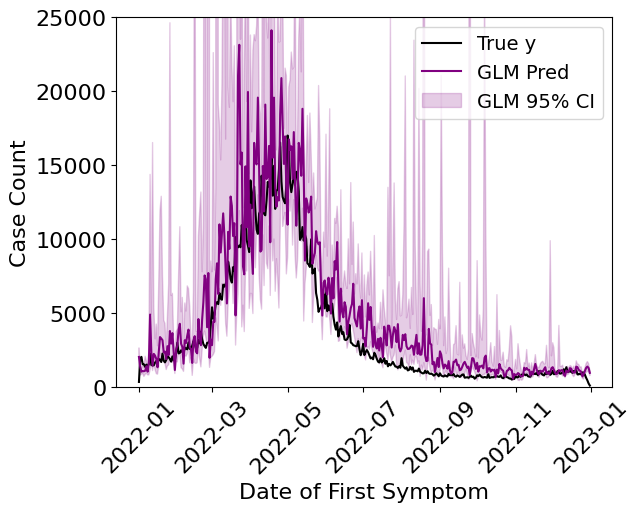

In [136]:
plt.plot(window_dates, y_true, label=f'True y', color="black")
plt.plot(window_dates, y_pred_med, label=f'GLM Pred', color="purple")
plt.fill_between(window_dates, y_pred_lower, y_pred_upper, color='purple', alpha=0.2, label='GLM 95% CI')



plt.legend(fontsize=14)
plt.tick_params(axis='x', rotation=45)
plt.xlabel("Date of First Symptom", fontsize=16)
plt.ylabel("Case Count", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0, 25000])
plt.savefig(project_dir/"src"/"outputs"/"visuals"/"same-day-nowcasts"/"GLM.png", dpi=600, bbox_inches="tight")
plt.show()





In [137]:
def compute_pica(y_true, y_pred, alpha=0.05):

    lower = np.quantile(y_pred, alpha / 2, axis=1)
    upper = np.quantile(y_pred, 1 - alpha / 2, axis=1)
    within_interval = (y_true >= lower) & (y_true <= upper)
    empirical_coverage = np.mean(within_interval)
    expected_coverage = 1 - alpha
    return np.abs(empirical_coverage - expected_coverage)

z_true = [dataset.__getitem__(i)[2] for i in range(T)]
z_true = np.array(z_true)[:,-1, :]
z_true.shape

def log_sum_exp(x, axis=None):
    m = np.max(x, axis=axis, keepdims=True)
    return m + np.log(np.sum(np.exp(x - m), axis=axis, keepdims=True))


loglik = np.zeros(shape=(N, T))
for n in range(N):
    dist_pred = NB(torch.tensor(mu_samples[:,:,n]), torch.tensor(theta_samples[:,:,n]))
    log_prob = dist_pred.log_prob(torch.tensor(z_true)).sum(1)
    loglik[n, :] = log_prob

print(f"GLM ELPD: {log_sum_exp(loglik, axis=1).mean()}")
print(f"GLM CRPS: {crps_ensemble(y_true, y_pred).mean()}")
print(f"GLM PICA: {compute_pica(y_true, y_pred, 0.05)}")

GLM ELPD: -104.22450817374548
GLM CRPS: 3735.2288763375805
GLM PICA: 0.24041095890410957
